In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---- Config
sims=20000
# 59,384.93
initial=20000
years=20
cagr=0.189
sharpe=1.500
sortino=1.890
max_drawdown=0.168
dividend_yield=0 #.0379

In [5]:
rng = np.random.default_rng()

@dataclass
class CalibratedParams:
    mu: float
    sigma: float
    sigma_up: float = None
    sigma_down: float = None
    asymmetric: bool = False

In [6]:

def calibrate_from_cagr_sharpe(cagr: float, sharpe: float) -> CalibratedParams:
    # Same quadratic as before:
    A, B, C = 0.5, -sharpe, np.log1p(cagr)
    disc = B*B - 4*A*C
    if disc < 0:
        raise ValueError("Infeasible CAGR/Sharpe combo.")
    sigma1 = sharpe - np.sqrt(disc)
    sigma2 = sharpe + np.sqrt(disc)
    sigma = sigma1 if sigma1 > 0 else sigma2
    mu = sharpe * sigma
    return CalibratedParams(mu=mu, sigma=sigma)


def simulate_paths_asym(params: CalibratedParams, years: int, sims: int, seed=None):
    rng = np.random.default_rng(seed)
    z = rng.standard_normal((sims, years))
    # Piecewise sigma: negative shocks use sigma_down, positive use sigma_up
    sig = np.where(z < 0, params.sigma_down, params.sigma_up)
    log_rets = (params.mu - 0.5 * (sig**2)) + sig * z
    return log_rets

def wealth_from_log_returns(initial: float, log_rets: np.ndarray) -> np.ndarray:
    sims, years = log_rets.shape
    wealth = np.empty((sims, years + 1))
    wealth[:, 0] = initial
    wealth[:, 1:] = initial * np.exp(np.cumsum(log_rets, axis=1))
    return wealth

def simulate_growth(
    initial: float,
    years: int,
    cagr: float,
    sharpe: float,
    sortino: float = None,   # <-- NEW (annual, rf≈0, MAR≈0)
    target_mdd: float = None,
    sims: int = 20000,
    seed: int = 42,
    return_log_returns: bool = True,
):
    """
    If sortino is provided, we use an asymmetric two-sigma model:
      - sigma_down = mu / sortino
      - sigma_total = mu / sharpe
      - sigma_up chosen so total variance matches sigma_total
    Otherwise, fall back to symmetric GBM.
    """
    params = calibrate_from_cagr_sharpe(cagr, sharpe)

    if sortino is not None:
        if sortino <= 0:
            raise ValueError("Sortino must be positive.")
        # downside deviation target
        sigma_down = params.mu / sortino

        # total sigma from Sharpe target
        sigma_total = params.sigma

        # approximate fraction of negative shocks under standard normal ~ 0.5
        p_neg, p_pos = 0.5, 0.5

        # Solve for sigma_up to match overall variance:
        # sigma_total^2 ≈ p_neg*sigma_down^2 + p_pos*sigma_up^2
        rhs = sigma_total**2 - p_neg * (sigma_down**2)
        if rhs <= 0:
            # Infeasible: Sortino too high vs Sharpe (downside too small). Nudge to feasible boundary.
            sigma_up = 1e-6
        else:
            sigma_up = np.sqrt(rhs / p_pos)

        params.sigma_down = float(sigma_down)
        params.sigma_up = float(sigma_up)
        params.asymmetric = True

        log_rets = simulate_paths_asym(params, years=years, sims=sims, seed=seed)
    else:
        log_rets = simulate_paths_sym(params, years=years, sims=sims, seed=seed)

    wealth = wealth_from_log_returns(initial, log_rets)
    terminal = wealth[:, -1]

    # Max drawdown per path
    def _mdd(path):
        peaks = np.maximum.accumulate(path)
        dd = (path / peaks) - 1.0
        return -dd.min()
    mdds = np.apply_along_axis(_mdd, 1, wealth)

    pct = np.percentile
    summary_df = pd.DataFrame(
        {
            "Metric": [
                "Inputs → CAGR",
                "Inputs → Sharpe",
                "Inputs → Sortino" if sortino is not None else "Inputs → Sortino",
                "Calibrated μ (cont.)",
                "σ_total (ann.)",
                "σ_up (ann.)" if params.asymmetric else "σ_up (ann.)",
                "σ_down (ann.)" if params.asymmetric else "σ_down (ann.)",
                f"Terminal Wealth (median) @ {years}y",
                "Terminal Wealth (p5)",
                "Terminal Wealth (p95)",
                "Terminal CAGR (median)",
                "Max Drawdown (median)",
                "Max Drawdown (p95)",
            ],
            "Value": [
                f"{cagr:.4f}",
                f"{sharpe:.4f}",
                (f"{sortino:.4f}" if sortino is not None else "—"),
                f"{params.mu:.4f}",
                f"{params.sigma:.4f}",
                (f"{params.sigma_up:.4f}" if params.asymmetric else "—"),
                (f"{params.sigma_down:.4f}" if params.asymmetric else "—"),
                f"${np.median(terminal):,.0f}",
                f"${pct(terminal, 5):,.0f}",
                f"${pct(terminal, 95):,.0f}",
                f"{(np.median(terminal/initial)**(1/years) - 1):.4f}",
                f"{np.median(mdds):.4f}",
                f"{pct(mdds, 95):.4f}",
            ],
        }
    )

    if target_mdd is not None:
        below = float(np.mean(mdds <= target_mdd))
        print(
            f"Target Max Drawdown: {target_mdd:.2%}\n"
            f"Simulated median MDD: {np.median(mdds):.2%}\n"
            f"Simulated 95th %-tile MDD: {pct(mdds,95):.2%}\n"
            f"Share of sims with MDD ≤ target: {below:.1%}"
        )

    return summary_df, params, terminal, mdds, wealth, (log_rets if return_log_returns else None)



In [7]:

# --- Demo run (you can edit these values or call simulate_growth yourself) ---
summary_df, params, terminal, mdds, wealth,_ = simulate_growth(
    initial=initial,     # starting dollars
    years=years,           # horizon
    cagr=cagr,          # expected CAGR (geometric mean)
    sharpe=sharpe,         # annual Sharpe (risk-free ~ 0)
    target_mdd=max_drawdown,    # optional: a target Max Drawdown like 30%
    sims=sims,
    sortino=sortino,
    seed=7,

)

Target Max Drawdown: 16.80%
Simulated median MDD: 0.00%
Simulated 95th %-tile MDD: 8.88%
Share of sims with MDD ≤ target: 99.8%


In [8]:
def plot_distribution(
    data: np.ndarray,
    title: str = "Distribution",
    xlabel: str = "Value",
    ylabel: str = "Frequency",
    show_kde: bool = True,
    show_hist: bool = True,
    bins: int = 50,
    percentiles: Tuple[int, int, int] = (5, 50, 95),
    format_dollar: bool = False,
    figsize=(10, 5),
):
    """
    Plot a distribution (histogram and/or KDE) with optional percentile markers.
    
    Args:
        data: Array-like of values (e.g. terminal wealth, CAGR, MDD)
        title: Chart title
        xlabel: X-axis label
        ylabel: Y-axis label
        show_kde: Show KDE (density curve)
        show_hist: Show histogram
        bins: Number of bins for histogram
        percentiles: Percentiles to mark (e.g. p5, median, p95)
        format_dollar: If True, formats x-axis labels as dollars
        figsize: Size of the figure
    """
    plt.figure(figsize=figsize)

    if show_hist:
        sns.histplot(data, bins=bins, kde=False, stat="density", color="skyblue", label="Histogram")

    if show_kde:
        sns.kdeplot(data, color="black", linewidth=2, label="KDE")

    # Add percentile lines
    for p in percentiles:
        val = np.percentile(data, p)
        plt.axvline(val, linestyle="--", label=f"P{p}: {val:,.0f}" if format_dollar else f"P{p}: {val:.4f}")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if format_dollar:
        plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:,.0f}"))
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


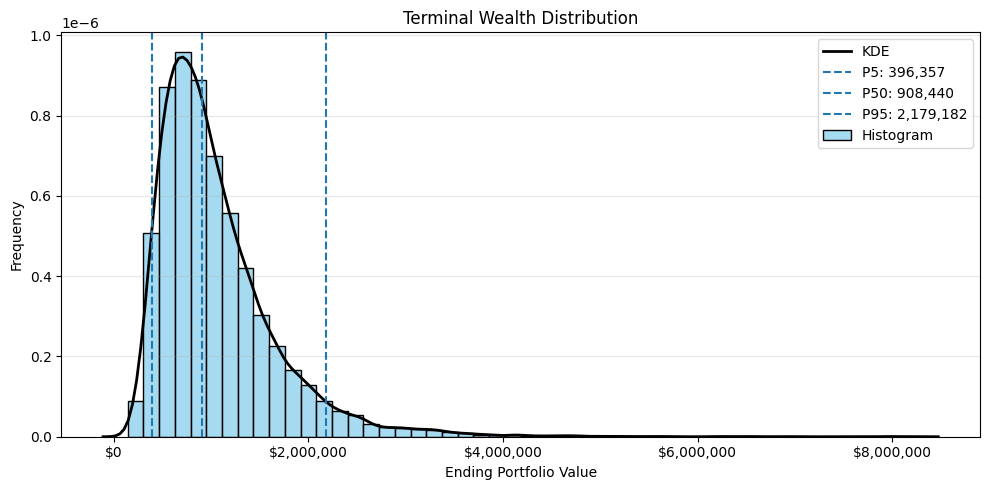

In [9]:
plot_distribution(
    terminal,
    title="Terminal Wealth Distribution",
    xlabel="Ending Portfolio Value",
    format_dollar=True,
)


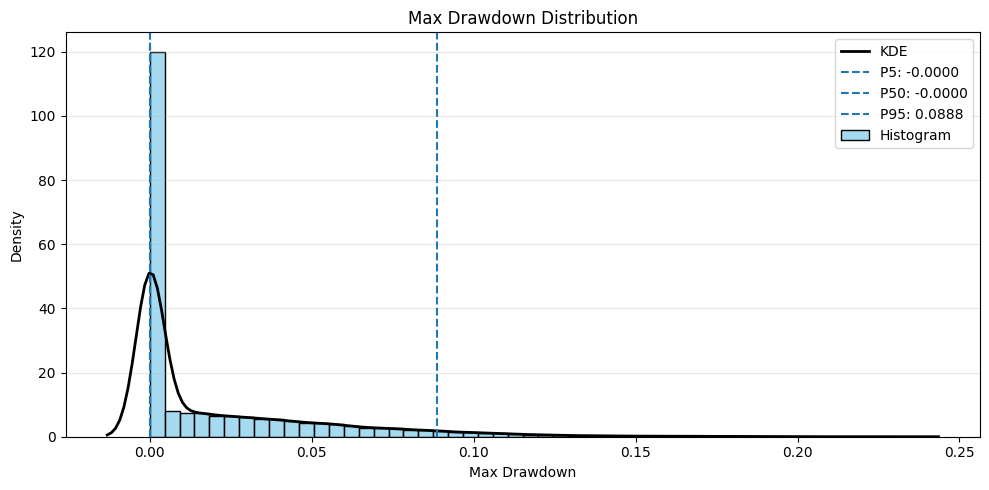

In [10]:
plot_distribution(
    mdds,
    title="Max Drawdown Distribution",
    xlabel="Max Drawdown",
    ylabel="Density",
    format_dollar=False
)


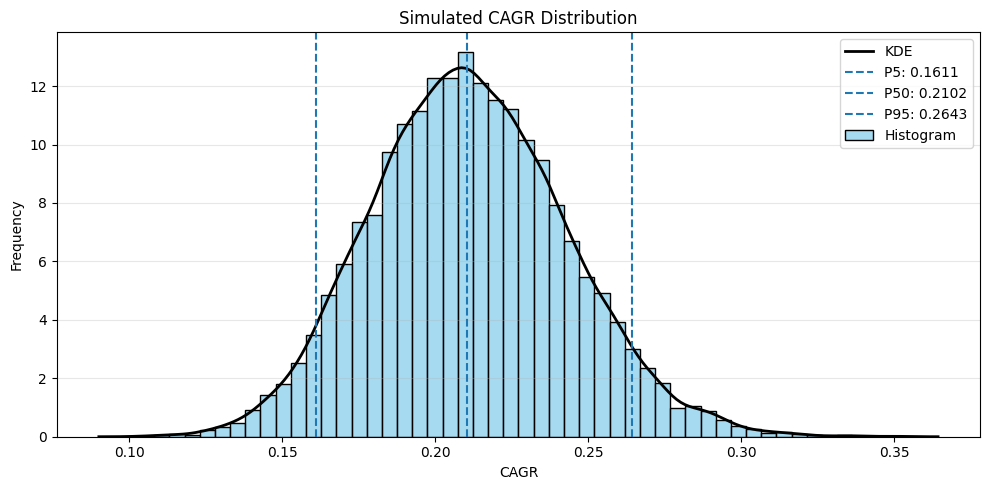

In [11]:
simulated_cagr = (terminal / initial) ** (1 / years) - 1
plot_distribution(
    simulated_cagr,
    title="Simulated CAGR Distribution",
    xlabel="CAGR",
    format_dollar=False
)


In [12]:
def plot_sustainable_spending(
    wealth: np.ndarray,
    cagr: float,
    years: int,
    percentiles=(5, 50, 95),
    dividend_yield: float = 0.0,
):
    """
    Time-series chart of sustainable annual spending in dollars:

        Spending_t ≈ (CAGR + dividend_yield) * Wealth_t

    Uses wealth paths from simulate_growth and plots chosen percentiles.

    Args:
        wealth: (sims, years+1) array from simulate_growth (t=0 is initial)
        cagr:   annual capital growth rate (decimal)
        years:  simulation horizon
        percentiles: percentiles across sims to plot
        dividend_yield: annual dividend yield (decimal, e.g., 0.03)
    """
    if wealth.ndim != 2:
        raise ValueError("wealth must be a 2D array of shape (sims, years+1).")
    sims, cols = wealth.shape
    if cols != years + 1:
        years = cols - 1

    # Total spending rate includes dividends
    spending_rate = cagr + dividend_yield

    # Spending taken at the start of each year
    spending = spending_rate * wealth[:, :-1]   # shape (sims, years)

    # Percentiles across simulations
    p = np.percentile(spending, q=list(percentiles), axis=0)
    labels = [f"P{q}" for q in percentiles]

    xs = np.arange(1, years + 1)
    plt.figure(figsize=(10, 5))
    for i, lab in enumerate(labels):
        plt.plot(xs, p[i], label=lab)

    plt.title("Maximum Sustainable Spending (Maintain Portfolio)")
    plt.xlabel("Year")
    plt.ylabel("Annual Spending ($)")

    from matplotlib.ticker import FuncFormatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y:,.0f}"))
    plt.legend()
    plt.tight_layout()
    plt.show()


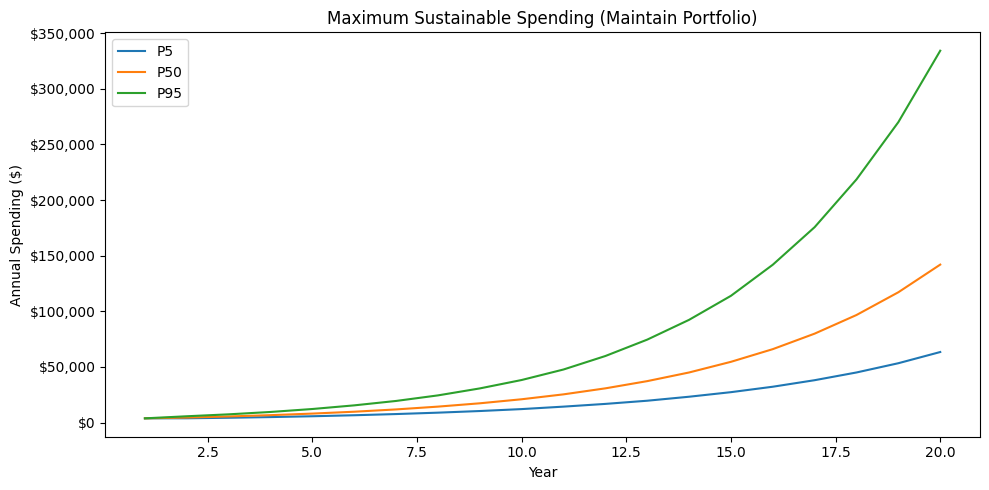

In [13]:
plot_sustainable_spending(wealth, cagr=cagr, years=years, dividend_yield=dividend_yield)